In [1]:
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [ ]:
df = pd.read_csv('./cleaned_data_daily.csv')
df = df['close'].values

In [ ]:
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
scaler = MinMaxScaler()
train = df[:-15]
test = df[-15:]
# train = train.reshape(-1,1)
# test = test.reshape(-1,1)
# scaler = scaler.fit(train)
# train_normalized = scaler.transform(train).squeeze()
# test_normalized = scaler.transform(test).squeeze()
train_normalized = train

In [ ]:
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})
fig, axes = plt.subplots(3, 2, sharex=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
axes[0, 0].plot(train_normalized)
axes[0, 0].set_title('Original Series')
plot_acf(train_normalized, ax=axes[0, 1], lags=30)


# 1st Differencing
axes[1, 0].plot(np.diff(train_normalized))
axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(train_normalized), ax=axes[1, 1],lags=30)


# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(train_normalized)))
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(train_normalized)), ax=axes[2, 1],lags=30)

plt.show()


In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.diff(train_normalized)) 
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(np.diff(train_normalized), ax=axes[1], lags=30)

plt.show()

In [ ]:
#ARIMA
model = ARIMA(train_normalized, order=(1,1,1), seasonal_order=(1, 1, 1, 7))
# model = ARIMA(train_normalized, order=(1,1,1))
model_fit = model.fit()
model_fit.summary()

In [ ]:
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})
model_fit.plot_diagnostics()
plt.show()

In [ ]:
plt.rcParams.update({'figure.figsize':(10,3)})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
fc = model_fit.forecast(15, alpha=0.05)

In [ ]:
# forecast, conf = fc.predicted_mean, fc.conf_int()
# fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test, label='actual')
plt.plot(fc, label='forecast')
plt.title('Forecast vs Actuals')
plt.show()

## AUTO ARIMA ##

In [2]:
threshold = -7
df = pd.read_csv('./cleaned_data_daily.csv')
df_ = np.log(df['close'].values)
train = df_[:threshold]
test = df_[threshold:]
# scaler = StandardScaler()
# train = scaler.fit_transform(train.reshape(-1,1)).squeeze()
# test = scaler.transform(test.reshape(-1,1)).squeeze()

In [3]:
model = pm.auto_arima(train,
                      start_p=10,
                      start_q=10,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, 
                      max_q=10, 
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(6,1,6)(1,0,1)[7] intercept   : AIC=-5956.585, Time=5.97 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-5969.726, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-5971.665, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-5971.241, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-5970.170, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-5973.220, Time=0.60 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=-5971.672, Time=0.70 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=-5970.028, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=-5974.010, Time=0.18 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=-5972.507, Time=0.58 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=-5972.519, Time=0.94 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=-5970.896, Time=0.35 sec
 ARIMA(3,1,0)(0,0,0)[7] intercept   : AIC=-5972.108, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=-5972.179, Time=0.99 sec
 ARIMA(1,1,1)(0,0,0

In [4]:
model.summary()
fc = model.predict(n_periods=-threshold)
fc

array([10.55245131, 10.54979147, 10.55010487, 10.5499781 , 10.54999782,
       10.54999152, 10.54999267])

In [5]:
model_ = sm.tsa.arima.ARIMA(train, order = (6,1,10), seasonal_order=(0, 0, 0, 7))
fitted = model_.fit()
fc_ = fitted.get_forecast(-threshold)
fc_ = (fc_.summary_frame(alpha=0.05))
fc_

C:\Users\Athra\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,10.550860,0.042010,10.468523,10.633198
1,10.549026,0.057601,10.436130,10.661922
2,10.549657,0.070947,10.410602,10.688711
3,10.550084,0.082216,10.388944,10.711224
4,10.547129,0.092335,10.366156,10.728102
5,10.544064,0.102091,10.343970,10.744159
6,10.545067,0.111519,10.326494,10.763640


In [6]:
appended_org = np.concatenate((train[-20:],test))
appended_fc = np.concatenate((train[-20:],fc))

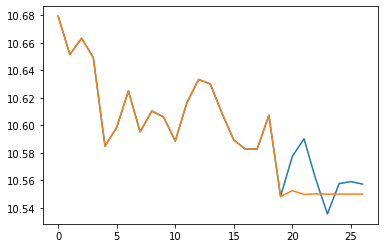

In [7]:
plt.plot(appended_org)
plt.plot(appended_fc)
plt.show()